In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_continuous import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 256
num_updates = 3000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: -191.77704931975686
max pF: 2.384938116772288
max photon: 24.65880297869444
photon time: 0.7428197447861723
smoothness: 0.005087343660085116
global update: 200
reward: -151.02544544909045
max pF: 2.560616818579245
max photon: 41.13502574712038
photon time: 0.8187370920671759
smoothness: 0.004074422136902968
global update: 300
reward: -116.43323310158956
max pF: 2.5609737962994705
max photon: 40.25551715493202
photon time: 0.8063498028204753
smoothness: 0.003291552399329601
global update: 400
reward: -77.57532008474683
max pF: 2.5628982642204834
max photon: 39.89603418111801
photon time: 0.7655321109183897
smoothness: 0.0024104002959961356
global update: 500
reward: -45.02314035723498
max pF: 2.562996016521817
max photon: 40.41325229406357
photon time: 0.7308153259004999
smoothness: 0.001653353209123773
global update: 600
reward: -25.971473368158975
max pF: 2.5637527180491846
max photon: 40.337393552064896
photon time: 0.67275766

In [7]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
actions = metrics["action"]

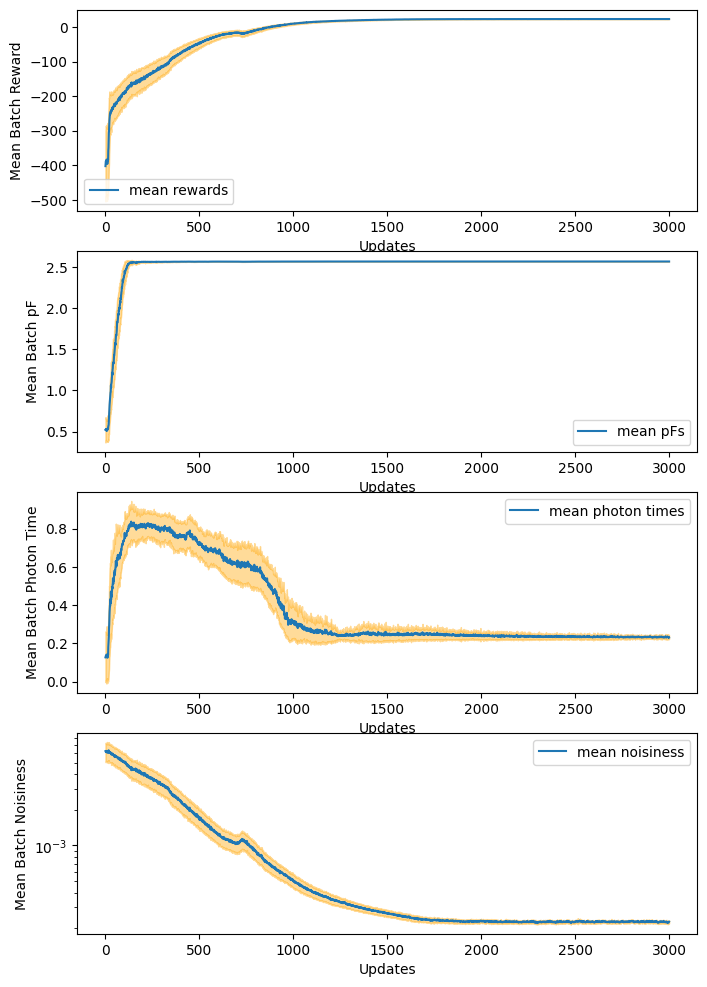

In [8]:
mean_rewards = jnp.mean(rewards, axis=-1)
std_rewards = jnp.std(rewards, axis=-1)

mean_pFs = jnp.mean(max_pFs, axis=-1)
std_pFs = jnp.std(max_pFs, axis=-1)

mean_times = jnp.mean(photon_times, axis=-1)
std_times = jnp.std(photon_times, axis=-1)

mean_smoothnesses = jnp.mean(smoothnesses, axis=-1)
std_smoothnesses = jnp.std(smoothnesses, axis=-1)

fig, ax = plt.subplots(4, figsize=(8.0, 12.0))

ax[0].plot(mean_rewards, label='mean rewards')
ax[0].fill_between(jnp.arange(num_updates), mean_rewards - std_rewards, mean_rewards + std_rewards, color='orange', alpha=0.4)
ax[0].set_xlabel('Updates')
ax[0].set_ylabel('Mean Batch Reward')
ax[0].legend()

ax[1].plot(mean_pFs, label='mean pFs')
ax[1].fill_between(jnp.arange(num_updates), mean_pFs - std_pFs, mean_pFs + std_pFs, color='orange', alpha=0.4)
ax[1].set_xlabel('Updates')
ax[1].set_ylabel('Mean Batch pF')
ax[1].legend()

ax[2].plot(mean_times, label='mean photon times')
ax[2].fill_between(jnp.arange(num_updates), mean_times - std_times, mean_times + std_times, color='orange', alpha=0.4)
ax[2].set_xlabel('Updates')
ax[2].set_ylabel('Mean Batch Photon Time')
ax[2].legend()

ax[3].plot(mean_smoothnesses, label='mean noisiness')
ax[3].fill_between(jnp.arange(num_updates), mean_smoothnesses - std_smoothnesses, mean_smoothnesses + std_smoothnesses, color='orange', alpha=0.4)
ax[3].set_xlabel('Updates')
ax[3].set_ylabel('Mean Batch Noisiness')
ax[3].set_yscale('log')
ax[3].legend()

plt.show()

### Increasing Fidelity Coefficent

In [9]:
single_train_2 = jit(PPO_make_train(config), static_argnums=(-2, -1))

snr_coeff_2 = 20.0

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result_2 = single_train_2(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff_2,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 3000 Updates
global update: 100
reward: -156.7191780341191
max pF: 2.5417635945803347
max photon: 32.85690650343895
photon time: 0.8679831956712847
smoothness: 0.004874929957326409
global update: 200
reward: -123.89469530485277
max pF: 2.561141976094949
max photon: 41.55817446112633
photon time: 0.9023879318207022
smoothness: 0.004022900528222531
global update: 300
reward: -89.26056031321933
max pF: 2.5606662111639307
max photon: 40.82872685790062
photon time: 0.833894480201215
smoothness: 0.0032371919721383927
global update: 400
reward: -48.382297674271214
max pF: 2.558619295676527
max photon: 40.375047385692596
photon time: 0.7687338008560971
smoothness: 0.0023097276390967626
global update: 500
reward: -5.3507229887047725
max pF: 2.556654327038464
max photon: 40.40079168975353
photon time: 0.6557985266693289
smoothness: 0.0013259965584966238
global update: 600
reward: 7.548120905807991
max pF: 2.555835534969297
max photon: 39.36955884099007
photon time: 0.5464708764

In [10]:
# Extracting Results

metrics_2 = single_result_2["metrics"]

rewards_2 = metrics_2["reward"]
max_pFs_2 = metrics_2["max pF"]
max_photons_2 = metrics_2["max photon"]
photon_times_2 = metrics_2["photon time"]
smoothnesses_2 = metrics_2["smoothness"]
actions_2 = metrics_2["action"]

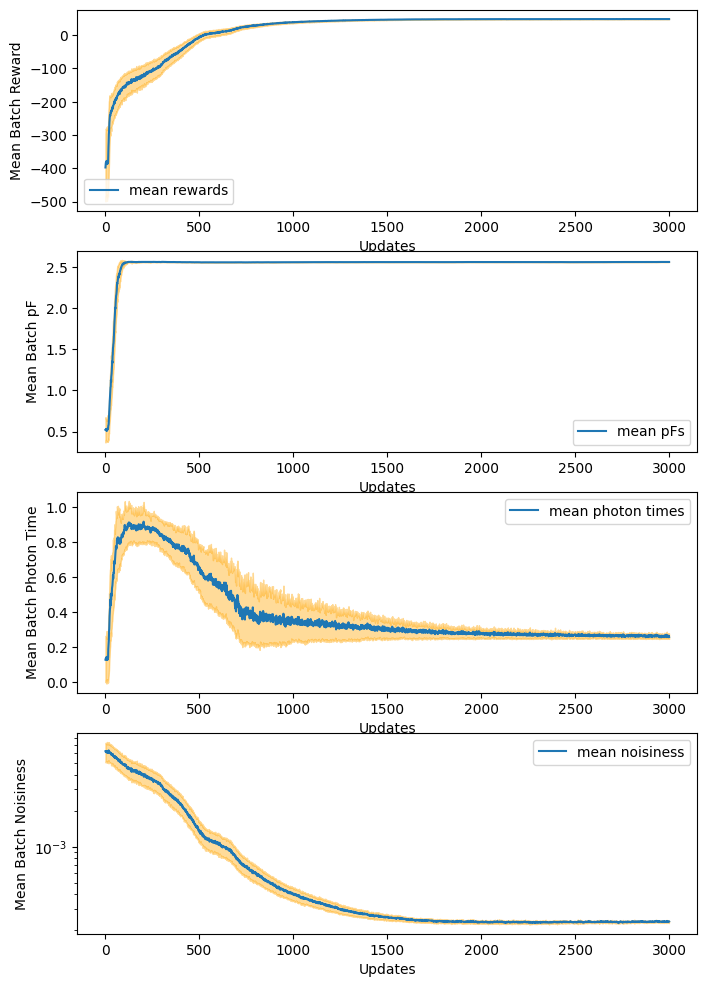

In [11]:
mean_rewards_2 = jnp.mean(rewards_2, axis=-1)
std_rewards_2 = jnp.std(rewards_2, axis=-1)

mean_pFs_2 = jnp.mean(max_pFs_2, axis=-1)
std_pFs_2 = jnp.std(max_pFs_2, axis=-1)

mean_times_2 = jnp.mean(photon_times_2, axis=-1)
std_times_2 = jnp.std(photon_times_2, axis=-1)

mean_smoothnesses_2 = jnp.mean(smoothnesses_2, axis=-1)
std_smoothnesses_2 = jnp.std(smoothnesses_2, axis=-1)

fig, ax = plt.subplots(4, figsize=(8.0, 12.0))

ax[0].plot(mean_rewards_2, label='mean rewards')
ax[0].fill_between(jnp.arange(num_updates), mean_rewards_2 - std_rewards_2, mean_rewards_2 + std_rewards_2, color='orange', alpha=0.4)
ax[0].set_xlabel('Updates')
ax[0].set_ylabel('Mean Batch Reward')
ax[0].legend()

ax[1].plot(mean_pFs_2, label='mean pFs')
ax[1].fill_between(jnp.arange(num_updates), mean_pFs_2 - std_pFs_2, mean_pFs_2 + std_pFs_2, color='orange', alpha=0.4)
ax[1].set_xlabel('Updates')
ax[1].set_ylabel('Mean Batch pF')
ax[1].legend()

ax[2].plot(mean_times_2, label='mean photon times')
ax[2].fill_between(jnp.arange(num_updates), mean_times_2 - std_times_2, mean_times_2 + std_times_2, color='orange', alpha=0.4)
ax[2].set_xlabel('Updates')
ax[2].set_ylabel('Mean Batch Photon Time')
ax[2].legend()

ax[3].plot(mean_smoothnesses_2, label='mean noisiness')
ax[3].fill_between(jnp.arange(num_updates), mean_smoothnesses_2 - std_smoothnesses_2, mean_smoothnesses_2 + std_smoothnesses_2, color='orange', alpha=0.4)
ax[3].set_xlabel('Updates')
ax[3].set_ylabel('Mean Batch Noisiness')
ax[3].set_yscale('log')
ax[3].legend()

plt.show()

## Decreasing Smoothness Coeff

In [18]:
num_updates_2 = 5000

config_2 = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "single_langevin_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

In [19]:
single_train_smo = jit(PPO_make_train(config_2), static_argnums=(-2, -1))

smoothness_coeff_2 = 5.0

print(f"Starting a Run of {num_updates_2} Updates")
start = time.time()
single_result_smo = single_train_smo(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff_2,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    # batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 5000 Updates
global update: 100
reward: -85.76002012623167
max pF: 2.5183556490534733
max photon: 30.86468470096588
photon time: 0.8222264346885216
smoothness: 0.004952645477233173
global update: 200
reward: -66.42674793059368
max pF: 2.554690290427471
max photon: 38.138952165842056
photon time: 0.8022563667713036
smoothness: 0.004022449923426328
global update: 300
reward: -40.120995479558346
max pF: 2.5548771088557904
max photon: 38.141680993139744
photon time: 0.6277832799842152
smoothness: 0.002856088897941477
global update: 400
reward: -22.570775422604008
max pF: 2.5555559411998026
max photon: 38.743099093437195
photon time: 0.41669322296693795
smoothness: 0.0021101276446600036
global update: 500
reward: -9.199614496956542
max pF: 2.5489926590496466
max photon: 35.993985421955585
photon time: 0.3735314461935919
smoothness: 0.0015330617023708868
global update: 600
reward: 1.5149159807418733
max pF: 2.557976597722471
max photon: 38.90281309187412
photon time: 0.3245

In [15]:
# Extracting Results

metrics_smo = single_result_smo["metrics"]

rewards_smo = metrics_smo["reward"]
max_pFs_smo = metrics_smo["max pF"]
max_photons_smo = metrics_smo["max photon"]
photon_times_smo = metrics_smo["photon time"]
smoothnesses_smo = metrics_smo["smoothness"]
actions_smo = metrics_smo["action"]

NameError: name 'num_updates_3' is not defined

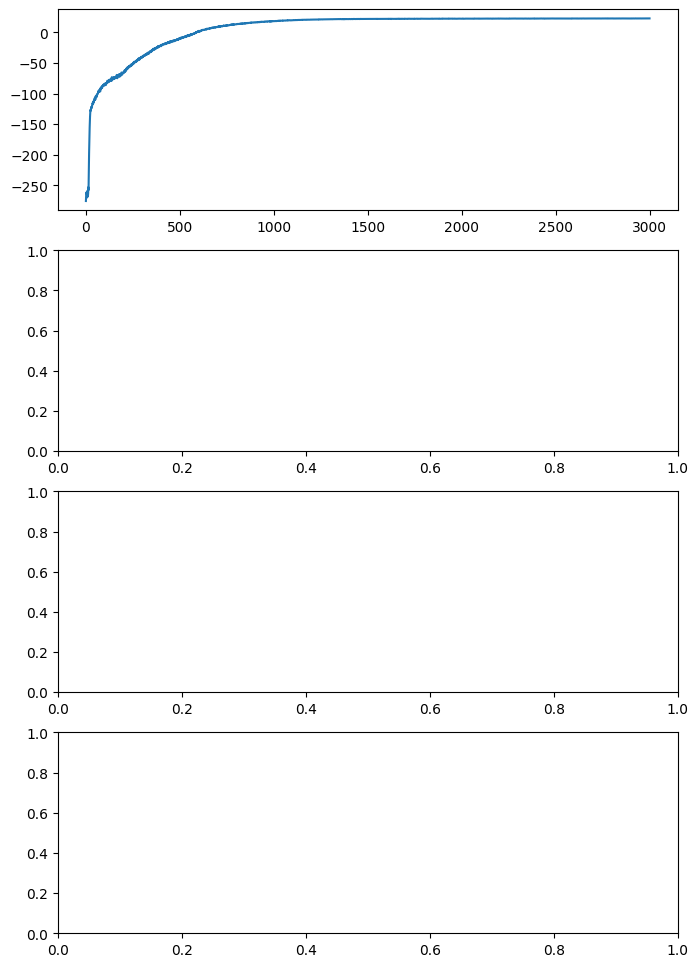

In [16]:
mean_rewards_smo = jnp.mean(rewards_smo, axis=-1)
std_rewards_smo = jnp.std(rewards_smo, axis=-1)

mean_pFs_smo = jnp.mean(max_pFs_smo, axis=-1)
std_pFs_smo = jnp.std(max_pFs_smo, axis=-1)

mean_times_smo = jnp.mean(photon_times_smo, axis=-1)
std_times_smo = jnp.std(photon_times_smo, axis=-1)

mean_smoothnesses_smo = jnp.mean(smoothnesses_smo, axis=-1)
std_smoothnesses_smo = jnp.std(smoothnesses_smo, axis=-1)

fig, ax = plt.subplots(4, figsize=(8.0, 12.0))

ax[0].plot(mean_rewards_smo, label='mean rewards')
ax[0].fill_between(jnp.arange(num_updates_3), mean_rewards_smo - std_rewards_smo, mean_rewards_smo + std_rewards_smo, color='orange', alpha=0.4)
ax[0].set_xlabel('Updates')
ax[0].set_ylabel('Mean Batch Reward')
ax[0].legend()

ax[1].plot(mean_pFs_smo, label='mean pFs')
ax[1].fill_between(jnp.arange(num_updates_3), mean_pFs_smo - std_pFs_smo, mean_pFs_smo + std_pFs_smo, color='orange', alpha=0.4)
ax[1].set_xlabel('Updates')
ax[1].set_ylabel('Mean Batch pF')
ax[1].legend()

ax[2].plot(mean_times_smo, label='mean photon times')
ax[2].fill_between(jnp.arange(num_updates_3), mean_times_smo - std_times_smo, mean_times_smo + std_times_smo, color='orange', alpha=0.4)
ax[2].set_xlabel('Updates')
ax[2].set_ylabel('Mean Batch Photon Time')
ax[2].legend()

ax[3].plot(mean_smoothnesses_smo, label='mean noisiness')
ax[3].fill_between(jnp.arange(num_updates_3), mean_smoothnesses_smo - std_smoothnesses_smo, mean_smoothnesses_smo + std_smoothnesses_smo, color='orange', alpha=0.4)
ax[3].set_xlabel('Updates')
ax[3].set_ylabel('Mean Batch Noisiness')
ax[3].set_yscale('log')
ax[3].legend()

plt.show()

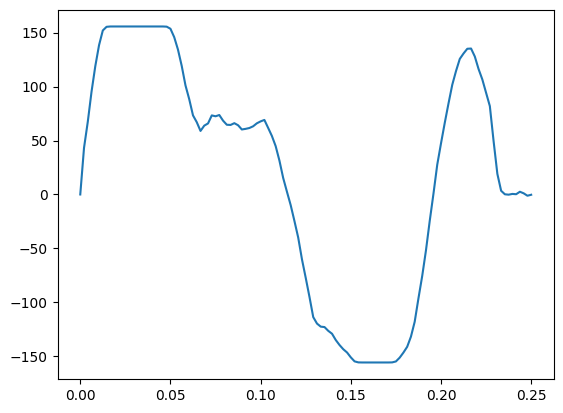

In [25]:
mean_actions_smo = -jnp.mean(actions_smo, axis=1)[-1]
smooth_action_smo = env.prepare_action(mean_actions_smo)
plt.plot(env.ts_action, smooth_action_smo)
plt.show()

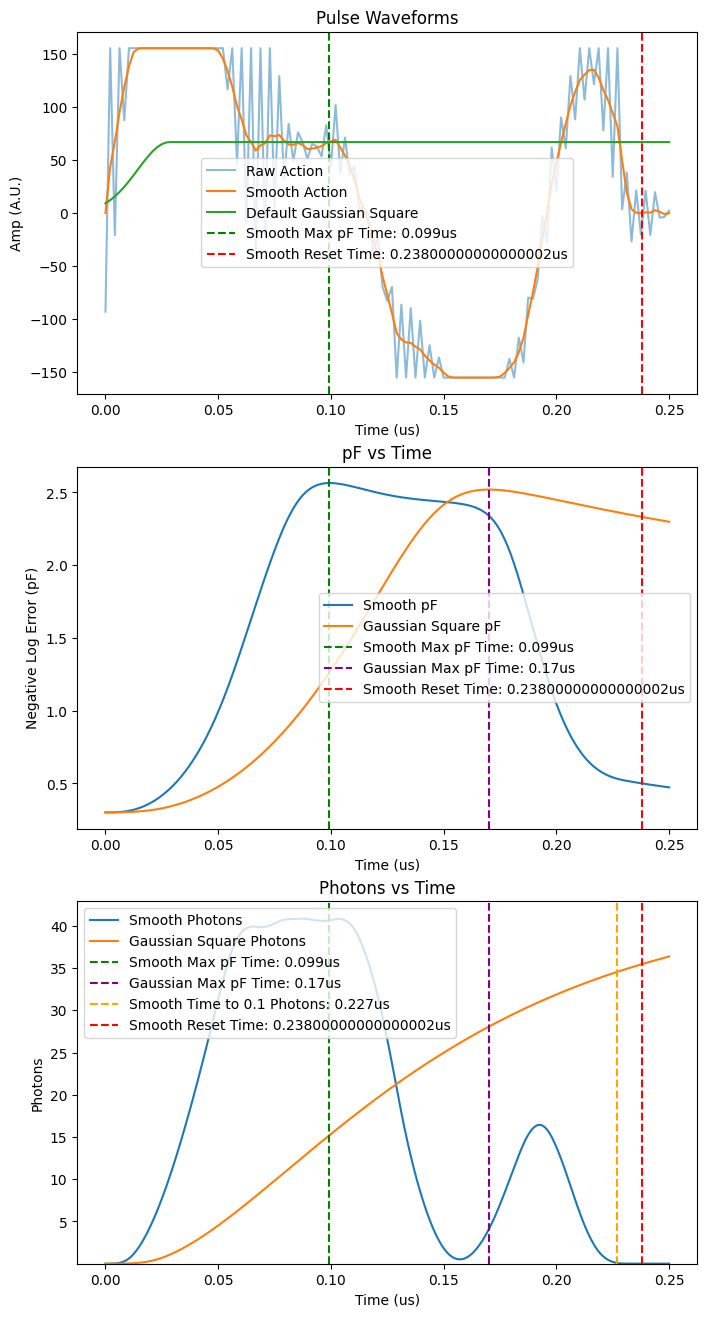

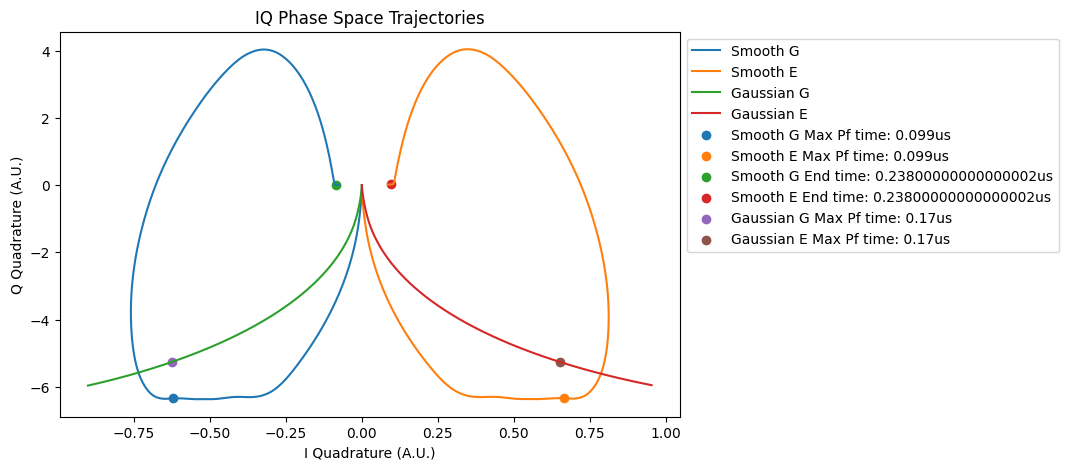

In [26]:
env.rollout_action(mean_actions_smo)

## Comparing Actions

In [25]:
# Evaluating Mean Action per Batch

mean_actions = jnp.mean(actions, axis=1)
mean_actions_2 = jnp.mean(actions_2, axis=1)
mean_actions_low = jnp.mean(actions_low, axis=1)

In [18]:
from envs.single_photon_env import SinglePhotonLangevinReadoutEnv

env = SinglePhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

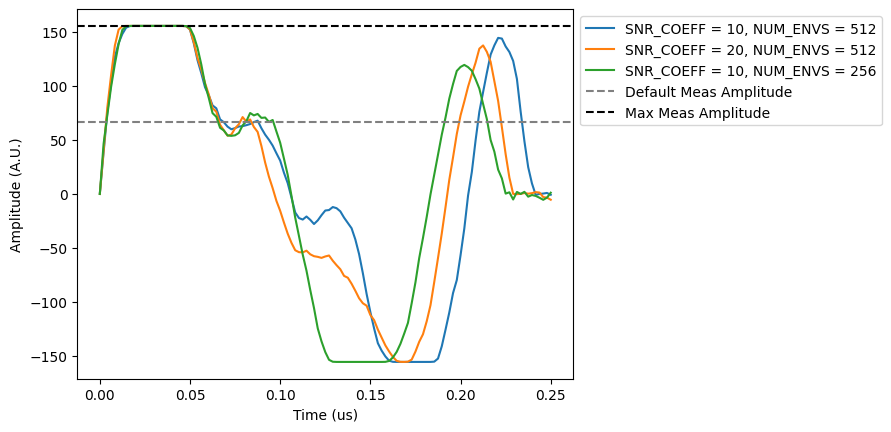

In [32]:
smooth_action = env.prepare_action(mean_actions[-1])
smooth_action_2 = env.prepare_action(mean_actions_2[-1])
smooth_action_low = env.prepare_action(-mean_actions_low[-1])

plt.plot(env.ts_action, smooth_action, label='SNR_COEFF = 10, NUM_ENVS = 512')
plt.plot(env.ts_action, smooth_action_2, label='SNR_COEFF = 20, NUM_ENVS = 512')
plt.plot(env.ts_action, smooth_action_low, label='SNR_COEFF = 10, NUM_ENVS = 256')
plt.axhline(y=env.a0, label='Default Meas Amplitude', linestyle='dashed', color='grey')
plt.axhline(y=env.a0 * env.mu, label='Max Meas Amplitude', linestyle='dashed', color='black')
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.show()

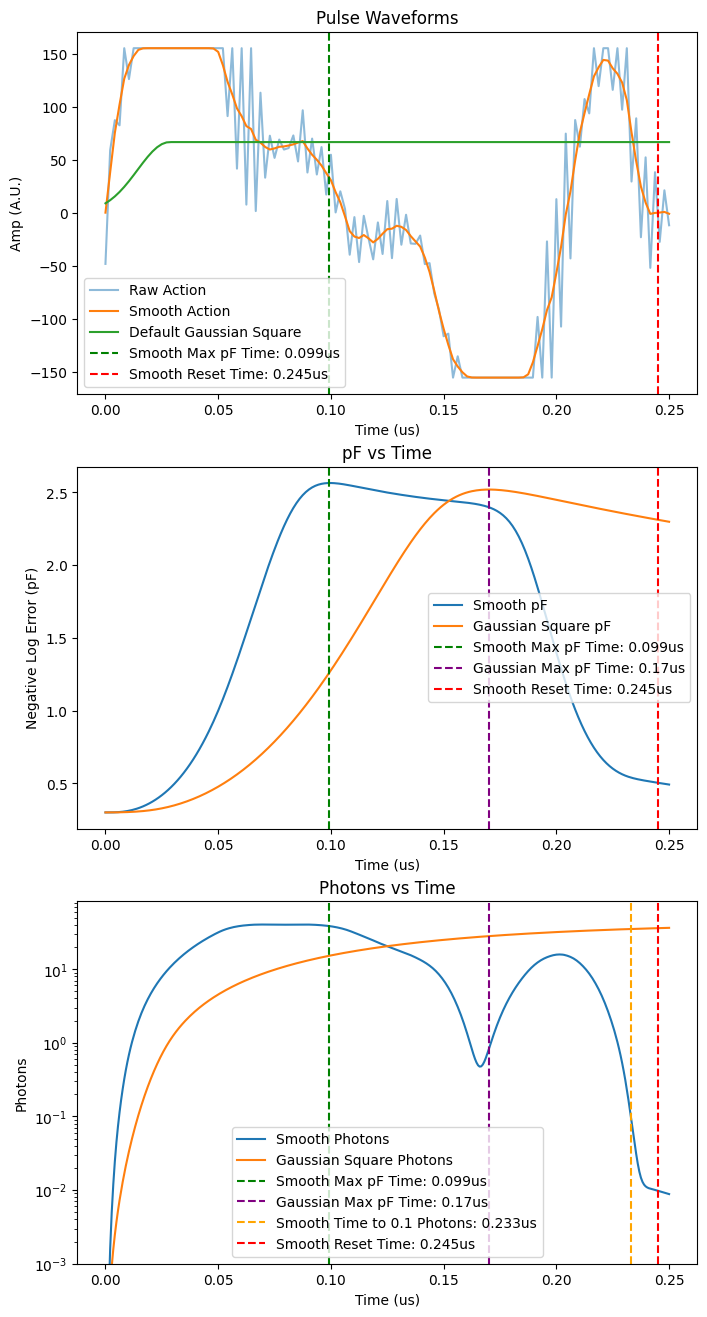

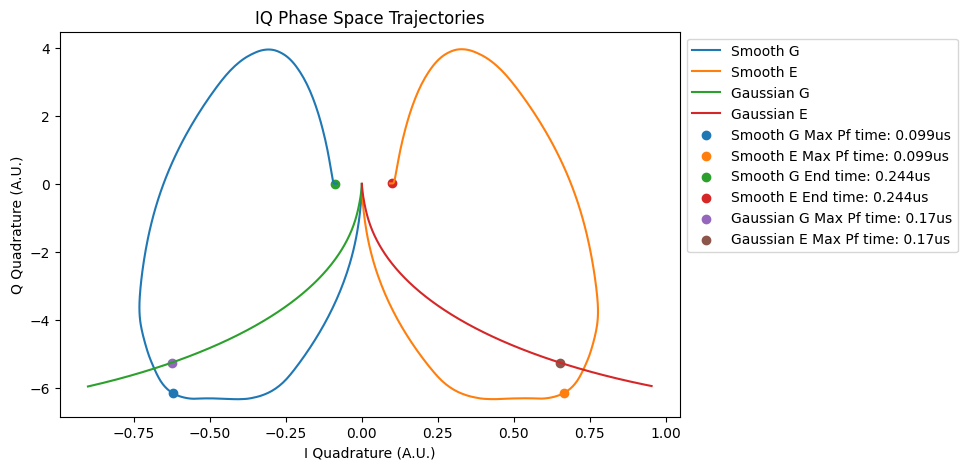

In [38]:
env.rollout_action(mean_actions[-1], photon_log_scale=True)

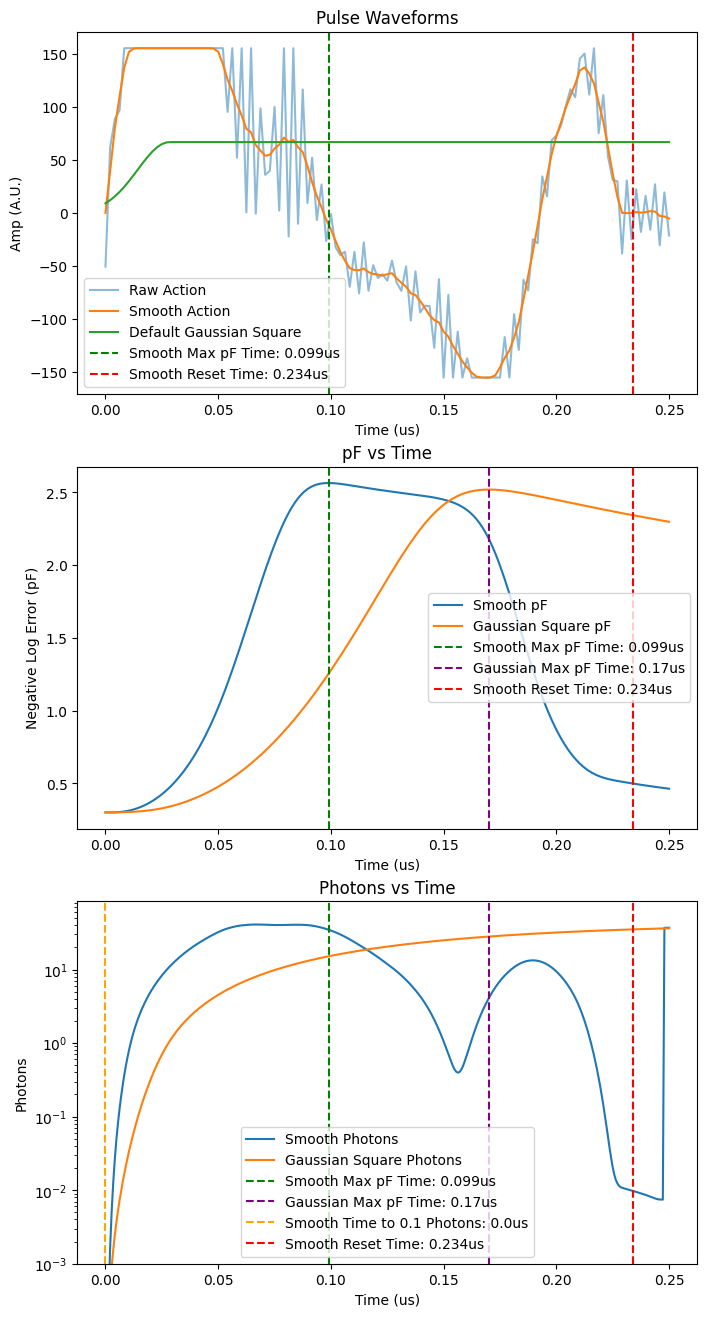

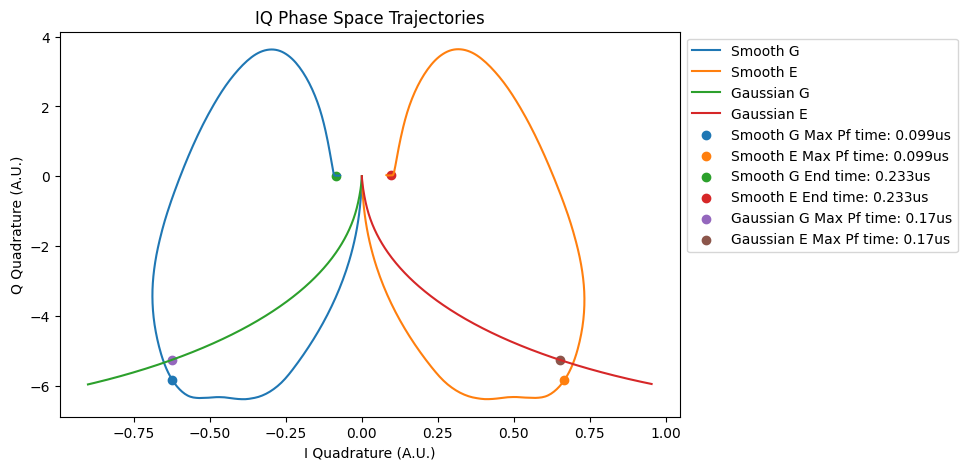

In [37]:
env.rollout_action(mean_actions_2[-1], photon_log_scale=True)

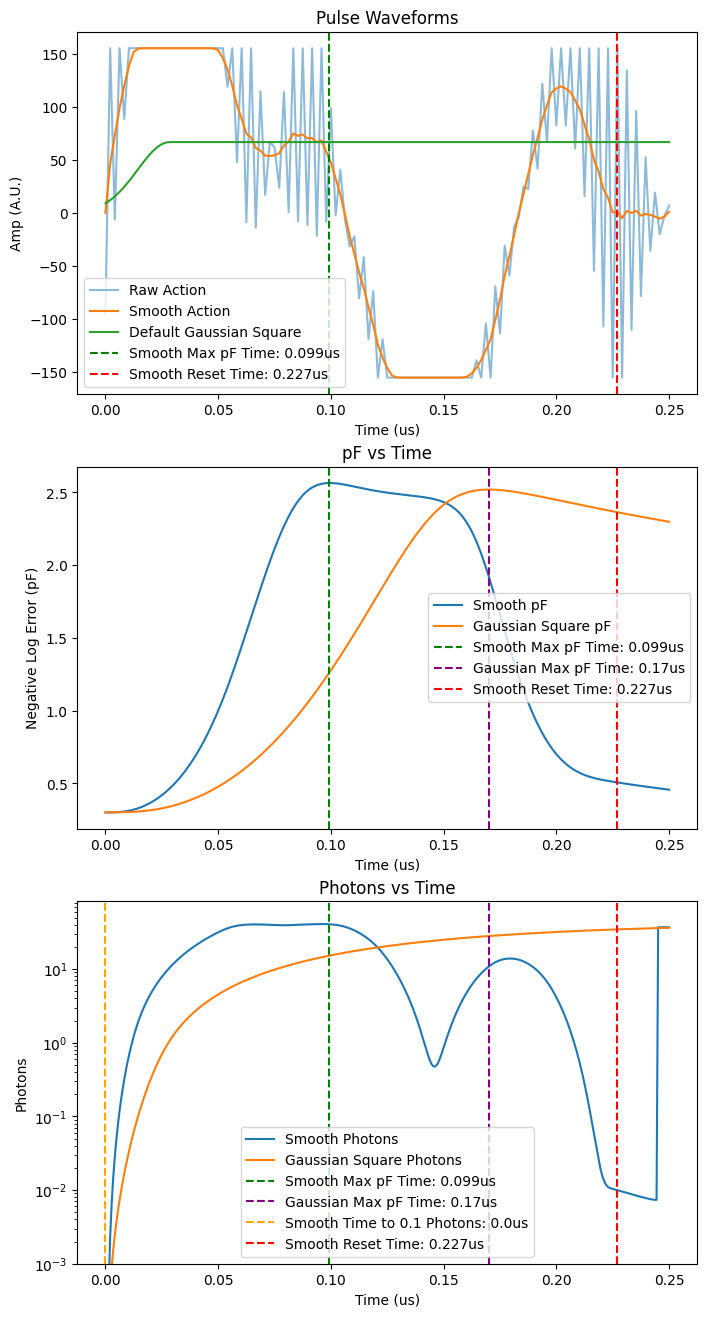

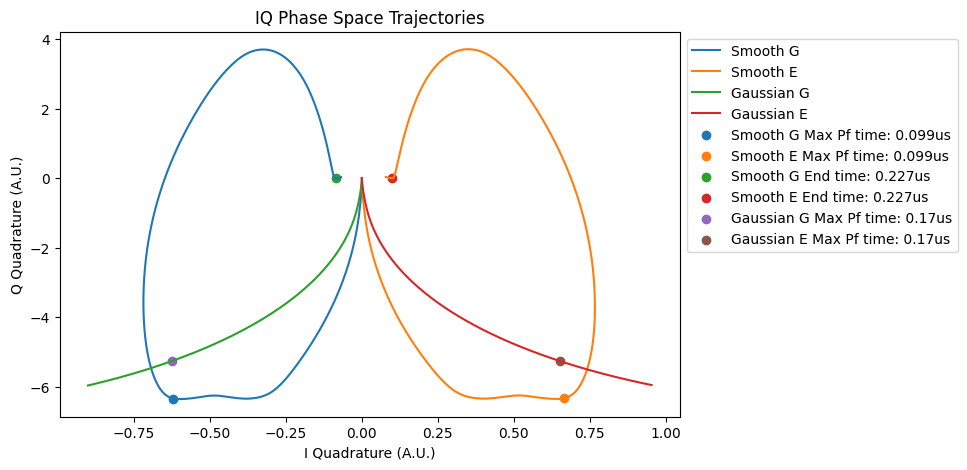

In [36]:
env.rollout_action(-mean_actions_low[-1], photon_log_scale=True)